In [1]:
import json
import os
import sys
import time
import numpy as np
import pandas as pd

from types import SimpleNamespace


from fincast.data_tools.TSdataset import TimeSeriesDataset_MultiCSV_train_Production

from fincast.tools.inference_utils import FinCast_Inference, plot_last_outputs

Loaded PyTorch FinCast, python version 3.11.13 (main, Jun  5 2025, 13:12:00) [GCC 11.2.0].


In [ ]:
#paths to set up

# data path -> #path to your data
# model_path -> #the pth file for model path
# save_output_path -> #path for saving your outputs.



data_path = ""               #path to your data

model_path = ""            #the pth file for model path

save_output_path = ""          #path for saving your outputs.



In [3]:
## set up 

config = SimpleNamespace()

#device
config.backend = "gpu"                    #cpu for cpu only, gpu for cuda gpu

#model path
config.model_path = model_path

#model version
config.model_version = "v1"           #only v1 for now, v1 is the 1b model in cikm 2025 paper, will release a better v2 soon with better performance and smaller size


#data related
config.data_path = data_path
config.data_frequency = "m"       #supports from second to year, use s for second, y for year and so for
config.context_len = 128             #input length for forecast input, from 32 to 1024
config.horizon_len =  32           #output length for forecast output, from 1 to 256

config.all_data = False               #boolean, False => only use the last input(input = context length), True =>  stride = 1, slices all input data and inference

config.columns_target = ['Close']             #the columns which you want to forecast, can use both int (index of that column) or str for column name

config.series_norm = False            #True for norm each series, false for not norm.

config.batch_size = 64                #go lower if you have a smaller vram.


#output related
config.forecast_mode = "mean"         #mean or median
config.quantile_outputs = []          #put in the optional quantile outputs you want, from q1 to q9, leave empty for nothing


config.save_output = True            #saves numeric outputs to csv
config.save_output_path = save_output_path

config.plt_outputs = True             #plt all the last outputs
config.plt_quantiles = [1, 3, 7, 9]             #quantiles to plt, from 1 to 9, use int



In [4]:
#auto run code, just run this cell
fincast_inference = FinCast_Inference(config)


preds, mapping, full_outputs = fincast_inference.run_inference()




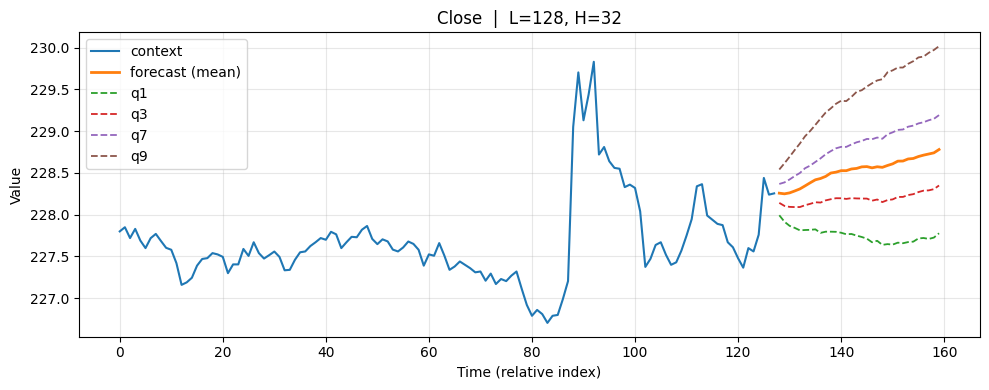

[saved] mean -> /home/vincent-4090/Documents/GitHub/FinCast-fts/results/fincast_mean_20250904_180504.csv
[saved] full  -> /home/vincent-4090/Documents/GitHub/FinCast-fts/results/fincast_full_20250904_180504.csv


In [5]:
if getattr(config, "plt_outputs", True):
    plot_last_outputs(
    fincast_inference=fincast_inference,
    mean_all=preds,
    mapping_df=mapping,
    full_all=full_outputs,
    config=config,
)